In [194]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [195]:
def prefixed_unnest(df: pl.DataFrame, column: str):
	df = df.with_columns(pl.col(column).struct.rename_fields([
		f"{column}.{field}" 
  		for field in df[column].struct.fields
	])).unnest(column)
	return df
    

In [196]:
df = pl.read_parquet("../results/2024-04-28/16-18-results.parquet")
df = prefixed_unnest(df, "reader")
df = prefixed_unnest(df, "workload")
df = df.explode("result")
df = prefixed_unnest(df, "result")
df = prefixed_unnest(df, "result.io")

In [197]:
ctx = pl.SQLContext(data=df)
df_to_plot = ctx.execute("SELECT `result.elapsed`, `result.io.read_count`, `result.io.read_chars`, `reader.name`, `workload.name` FROM data",
       eager=True)
df_to_plot = df_to_plot.to_pandas()

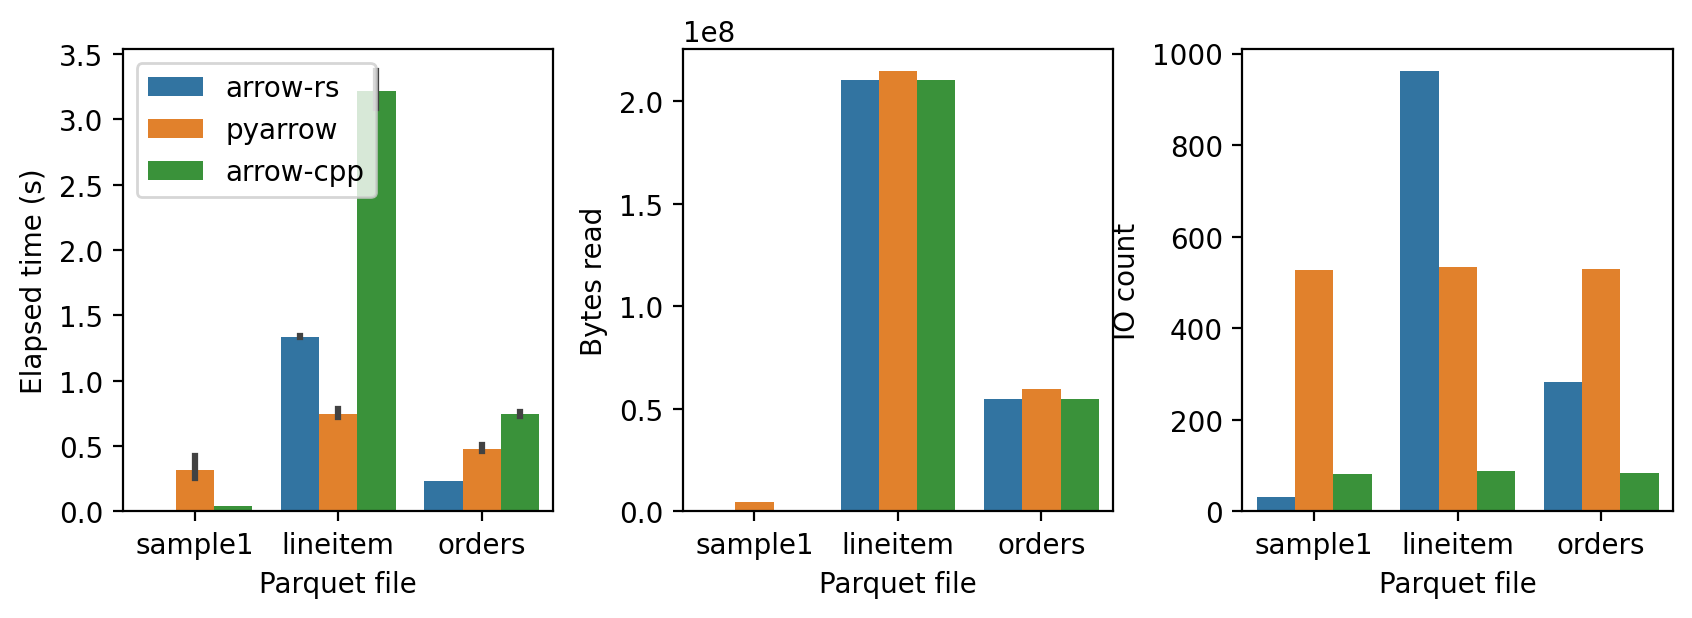

In [200]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
fig.subplots_adjust(wspace=0.3)

sns.barplot(ax=axes[0], x="workload.name", y="result.elapsed", hue="reader.name", data=df_to_plot)
sns.barplot(ax=axes[1], x="workload.name", y="result.io.read_chars", hue="reader.name", data=df_to_plot)
sns.barplot(ax=axes[2], x="workload.name", y="result.io.read_count", hue="reader.name", data=df_to_plot)

axes[0].set_ylabel("Elapsed time (s)")
axes[1].set_ylabel("Bytes read")
axes[2].set_ylabel("IO count")
for ax in axes:
    ax.set_xlabel('Parquet file')
axes[0].legend(title = '')
axes[1].legend().remove()
axes[2].legend().remove()

fig.savefig("../results/leaderboard.png", bbox_inches='tight')